In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pvlib
import cpvlib

In [16]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data_tmy = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

data = data_tmy#['2010-06-01':'2010-06-01']

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solpos = location.get_solarposition(data.index)

In [17]:
# %% Parámetros
# R_sh_exp = 5.5, # exp. R paral VALOR_DEFECTO
# EgRef = 1.121, # VALOR_DEFECTO
# irrad_ref = 1000,
# temp_ref = 25

modulo = 'insolight'

if modulo == 'insolight':
    # Insolight (César)
    cpv_mod_params = {
        "alpha_sc": 0.00,
        "gamma_ref": 5.524,
        "mu_gamma": 0.003,
        "I_L_ref": 0.96,
        "I_o_ref": 1.7e-10,
        "R_sh_ref": 5226,
        "R_sh_0": 21000,
        "R_s": 0.01,
        "EgRef": 3.91,
        "cells_in_series": 12,
    }

    A = 0.10  # m2

    # UF
    # para usa los UF hay que llamar a static_cpv_sys.get_global_utilization_factor_cpv()
    # UF_parameters_cpv = {
    #     "IscDNI_top": 0.96 / 1000,
    #     "am_thld": 4.574231933073185,
    #     "am_uf_m_low": 3.906372068620377e-06,
    #     "am_uf_m_high": -3.0335768119184845e-05,
    #     "ta_thld": 50,
    #     "ta_uf_m_low": 4.6781224141650075e-06,
    #     "ta_uf_m_high": 0,
    #     "weight_am": 0.2,
    #     "weight_temp": 0.8,
    # }

    # cpv_mod_params.update(UF_parameters_cpv)

elif modulo == 'soitec':
    # Soitec CX-M500
    cpv_mod_params = {
        "alpha_sc": 0.00,
        "gamma_ref": 3.664,
        "mu_gamma": 0.003,
        "I_L_ref": 3.861,
        "I_o_ref": 0.005e-9,
        "R_sh_ref": 3461,
        "R_sh_0": 25000,
        "R_s": 0.61,
        "EgRef": 3.91,
        "cells_in_series": 240,
        "irrad_ref": 943,
        "temp_ref": 64
    }

    A = 7.386  # m2

In [18]:
#%% calcula Pmp STC
Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticCPVSystem(
    module_parameters=cpv_mod_params
).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = Pdc_stc / (1000 * A)
print(f'Pdc_stc={Pdc_stc:.0f} W, eff_a={eff_a:.2%}')

temp_mod_params = {"eta_m": 0.32, "alpha_absorption": 0.9}
# print(temp_mod_params)

Pdc_stc=30 W, eff_a=30.01%


In [19]:
# %% Modelo PVSyst
static_cpv_sys = cpvlib.StaticCPVSystem(
    surface_tilt=37,
    surface_azimuth=180,
    # albedo=0.2,
    module_parameters=cpv_mod_params,
    in_singleaxis_tracker=False,
    temperature_model_parameters=temp_mod_params,
    modules_per_string=1,
)

# AOI
aoi = static_cpv_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)
# aoi.plot()

irradiance = static_cpv_sys.get_irradiance(
    solpos['zenith'], solpos['azimuth'], data['dni'])

iam_param = 0.67
effective_irradiance = irradiance * \
    static_cpv_sys.get_iam(aoi, iam_param)

cell_temp = static_cpv_sys.pvsyst_celltemp(
    poa_global=effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

diode_parameters = static_cpv_sys.calcparams_pvsyst(
    effective_irradiance=effective_irradiance,
    temp_cell=cell_temp,
)

power = static_cpv_sys.singlediode(*diode_parameters)

C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib.py:205: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [20]:
#%%
Yr = irradiance.resample('M').sum() / 1000
Yr_effective = effective_irradiance.resample('M').sum() / 1000
Ya = power['p_mp'].resample('M').sum() / Pdc_stc

Lc = Yr - Ya
Lc_effective = Yr_effective - Ya

PR = Ya / Yr

print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW, Yr_effective={Yr_effective.sum():.0f} kWh/kW')

PR=0.73, Ya=1097 kWh/kW, Yr=1498 kWh/kW, Yr_effective=1160 kWh/kW


<IPython.core.display.Javascript object>


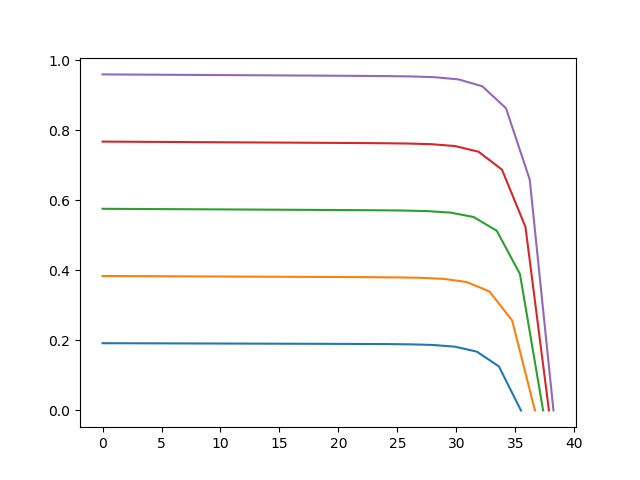

In [21]:
# %% Curvas IV vs G,Tc
plt.figure()
for G in [200, 400, 600, 800, 1000]:
    d = static_cpv_sys.singlediode(*static_cpv_sys.calcparams_pvsyst(
        effective_irradiance=G,
        temp_cell=25,
    ), ivcurve_pnts=20
    )
    plt.plot(d['v'], d['i'])

<IPython.core.display.Javascript object>


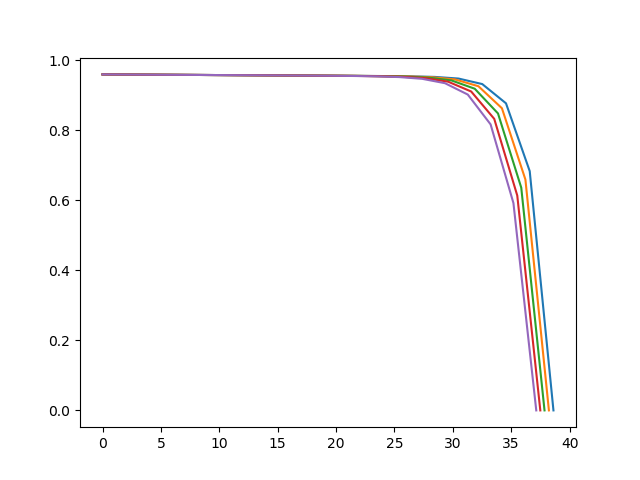

In [22]:
plt.figure()
for t in [10, 25, 40, 55, 70]:
    d = static_cpv_sys.singlediode(*static_cpv_sys.calcparams_pvsyst(
        effective_irradiance=1000,
        temp_cell=t,
    ), ivcurve_pnts=20
    )
    plt.plot(d['v'], d['i'])

<IPython.core.display.Javascript object>


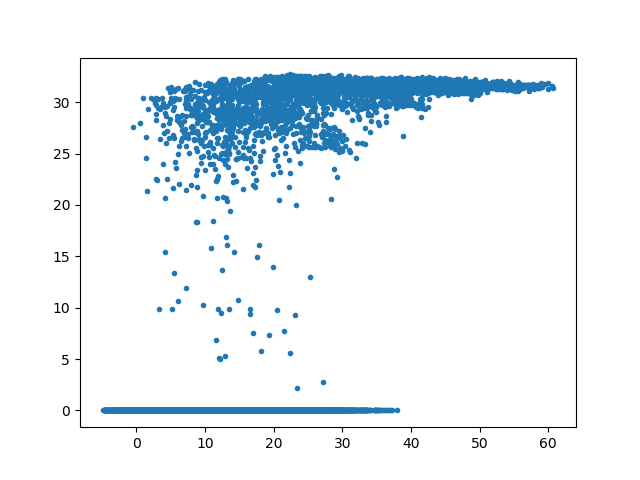

In [23]:
# %% Grafica V_mp vs cell_temp
plt.figure()
plt.plot(cell_temp, power['v_mp'], '.')

<IPython.core.display.Javascript object>


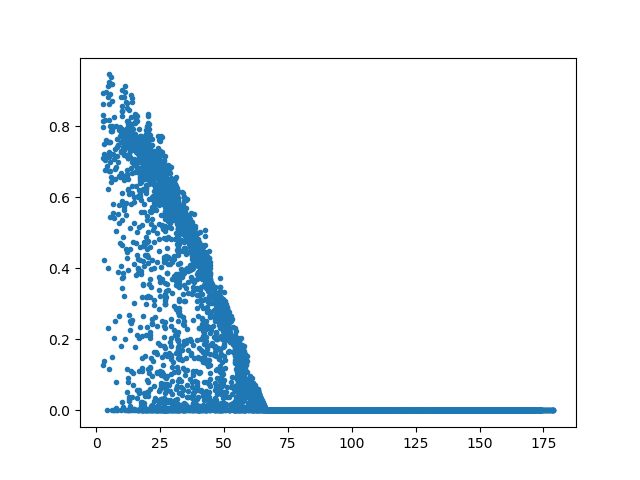

In [24]:
# %% Grafica I_mp vs aoi
plt.figure()
plt.plot(aoi, power['i_mp'], '.')